In [19]:
import pandas as pd
import os

from src.evaluation_tool.layered_tool import FairKit

# Ensure working directory is in root of repository and not in location of notebook
cwd = os.getcwd()
if cwd[-9:] == 'notebooks':
    os.chdir('../')

'C:\\Users\\elisa\\Documents\\DTU\\Fairness-oriented-interpretability-of-predictive-algorithms'

# Demonstration of FairKit
*Authors:* Caroline Amalie Fuglsang-Damgaard, Elisabeth Zinck

The following notebook is a demonstration of the FairKit class, which can be used for evaluating the fairness of a binary classification model.

The FairKit class is a 3-layer toolkit for analysing and understanding how much unfairness is present in predictions from a given predictive algorithm. It analyses the unfairness by subgroups dictated by a sensitive attribute such as sex or race. The three layers of FairKit each returns a visualization and the data behind. Moreover, it is designed such that each layer should nuance the analysis and aid the user to a deeper understanding of the predictions. $\color{red}{\text{TODO: We might need something about 'please read here for thorough walktrough'}}$

## Data 
This demonstration will use the canonical COMPAS dataset, which was analyzed in ProPublica's [article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) about machine bias in criminal sentencing. 

To shortly summarize: the COMPAS algorithm assigns a decile score between 1 and 10 to a criminal. A score above 5 means that the criminal is considered to have medium(6-8) or high(9-10) risk of comitting another crime (recidivating) within two years. The prediction of the binary classification of the $\text{i}^{\text{th}}$ criminal is given by
$$
\text{pred}_i = \begin{cases}
    0 &\text{decile\_score}_i <= 5\\
    1 &\text{decile\_score}_i > 5
\end{cases}
$$
and the target variable is whether the individual recidivated within two years (`two_year_recid`). 

The dataset is available [here](https://github.com/propublica/compas-analysis), and the preprocessing consisted of 
- Subsetting to individuals with races African-American and Caucasian
- Exclude individuals with `days_b_screening_arrest` $\leq$ 30 and `days_b_screening_arrest` $\geq$ -30 because data quality is questionable
- Exclude individuals with `screening_date` $>$ '2014-04-01' (see REF)

In [20]:
# Loading Processed Data Set
compas_file_path = 'data/processed/compas/compas-scores-two-years-pred.csv'
compas = pd.read_csv(compas_file_path)
compas.head(5)

,id,sex,age,age_cat,race,decile_score,score_text,two_year_recid,pred
0,3,Male,34,25 - 45,African-American,3,Low,1,False
1,4,Male,24,Less than 25,African-American,4,Low,1,False
2,8,Male,41,25 - 45,Caucasian,6,Medium,1,True
3,10,Female,39,25 - 45,Caucasian,1,Low,0,False
4,14,Male,27,25 - 45,Caucasian,4,Low,0,False


## Initialization of Class
The following section shows how the FairKit class is initialized. To initialize the class one must specify: 

* **data**: DataFrame containing data used for evaluation
*  **y_name**: Name of target variable
* **y_hat_name**: Name of binary output variable
* **r_name**: Name of variable containing scores (scores must be within [0,1])
* **a_name**: Name of sensitive variable 
* **w_fp**: False positive error rate
* **model_name**: Name of the model or dataset used. Is used for plot titles. (Optional)
 

The COMPAS dataset will be analyzed wrt. discrimination by race. Because decile scores range from 1-10 they must be divided by 10 prior to initializing the class.  

In [21]:
compas = compas.assign(decile_score = lambda x: x.decile_score/10)

Then the data is ready for the class to be initialized. The False Positive Error weight $w_{FP} \in [0,1]$ balances the severity of recieving a false positive vs. a false negative. Because it can have severe negative consequences to be classified as a possible recidivist, it is suitable to choose a high weight such as $w_{FP} = 0.9$.

In [22]:
compas_w_fp = 0.9
fair_compas = FairKit(
    data = compas,
    y_name = "two_year_recid", 
    y_hat_name = "pred", 
    a_name = "race", 
    r_name = "decile_score",
    w_fp = compas_w_fp,
    model_name='COMPAS Decile Scores')

## Layer 1 - Single Unfairness Measure

The first layer should be used to get a really quick overview of whether there is unfairness present in the predictions and how much. For this, the maximum relative difference in percent between the sensitive groups' weighted misclassification rates (WMR) is used.

WMR of sensitive group $a$ is defined as
$$
    \textit{WMR}_a = c(w_{FP})\cdot\frac{w_{FP} FP_a + (1-w_{FP})FN_a}{N_a},
$$
where $FP_a$ is the number of false positives in group $a$, $FN_a$ is the number of false negatives in group $a$, $N_a$ is the number of classified observations belonging to group $a$, and $w_{FP}$ is the weight indicating the severity of a false positive. $c(w_{FP})$ is a normalization constant ensuring that $\textit{WMR} \in [0,1]$

The results from the first layer of FairKit is accessed by:

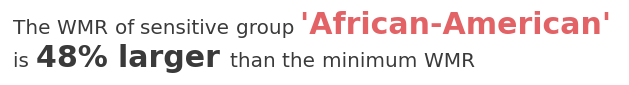

In [23]:
layer1_output_data = fair_compas.layer_1()

In [24]:
layer1_output_data

,grp,n,weighted_misclassification_ratio
0,African-American,2682,47.877821
1,Caucasian,1829,0.000000


From the illustration above it is seen that the group "African-American" sees a 48% larger *WMR* (weighted misclassification rate) compared to the group with the smallest *WMR*, which suggests that the predictions disfavor African-Americans. The illustration always shows the largest ratio, and should be seen as a red flag highlighting the most disfavored group. 

The table shows that Caucasians have the smallest *WMR* and therefore a ratio of 0%. The table includes one row for each sensitive group. 

The weighted classification ratio can be used to compare the degree of unfairness between different models. 

## Layer 2 - Overview of Unfairness
The second layer of FairKit provides a comprehensive overview of the unfairness present in the predictions of the predictive model. It creates the overview through a visualization consisting of three components: 
* **Group rates**: The false positive rate (FPR), false negative rate (FNR), false discovery rate (FDR) and false omission rate (FOR) for each sensitive group.
* **Relative rates**: The relative difference in percent of each rate, including the *WMR*, between each sensitive group and the group with the smallest value of that given rate. 
* **Unfairness barometer**: This barometer shows the degree of measured unfairness in the predictions based on many of the frequently used fairness criteria in fairness research, e.g. separation (equalized odds). The color of the bar corresponds to the color of the disfavored group according to the criterion. 

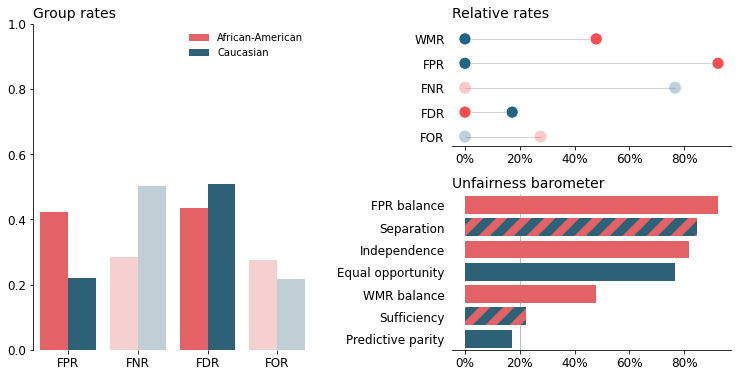

In [25]:
rates, relative_rates, barometer = fair_compas.layer_2()

The plot shows that African-Americans have almost twice as high false positive rates as Caucasians. This results in the unfairness barometer being the largest for FPR balance and separation since these fairness criteria are based on the false positive rate. 

The false negative rate is much higher for Caucasians than for African-Americans, which results in large violations of the criteria Equal opportunity and separation. 

Since $w_{FP} = 0.9$, a false positive prediction is considered to be more severe than a false negative. The WMR balance takes this trade-off into account, and hence deem African-Americans to be more disfavored than Caucasians. 

Finally, the independence criterion is violated, which means that African-Americans have a higher rate of receiving the unfavorable prediction. 

In [26]:
# Data from the layer
relative_rates.head()

,grp,rate,rate_val,relative_rate
0,African-American,FDR,0.434282,0.000000
1,Caucasian,FDR,0.509025,17.210811
2,African-American,FNR,0.285103,0.000000
3,Caucasian,FNR,0.503650,76.655488
4,African-American,FOR,0.276119,27.555159


In [27]:
barometer

,criterion,relative_rate,discriminated_grp
1,FPR balance,92.323421,[African-American]
4,Separation,84.489454,"[Caucasian, African-American]"
2,Independence,81.690209,[African-American]
0,Equal opportunity,76.655488,[Caucasian]
6,WMR balance,47.877821,[African-American]
5,Sufficiency,22.382985,"[Caucasian, African-American]"
3,Predictive parity,17.210811,[Caucasian]


## Layer 3 - Analysis of Unfairness Sources

Based on layer 2 it is possible to investigate further where the unfairness stems from. Layer 3 currently includes the following methods:
- `w_fp_influence`: Shows how different settings of `w_fp` influence the weighted misclassification ratio or rate. 
- `roc_curves`: ROC curves for each sensitive group. Suitable if the unfairness barometer shows high disparities in *separation*, *FPR balance* or *Equal opportunity*. 
- `calibration`: Calibration curve for each sensitive group. Suitable if the unfairness barometer shows high disparities in *sufficiency*.
- `confusion_matrix`: Display a confusion matrix for each sensitive group. 
- `independence_check`: Fraction of individuals predicted to most unfavored outcome. Suitable if there are high disparities in *independence*. 

In this example using COMPAS, independence and separation shows the biggest differences between groups, so the methods `roc_curves` and `independence_check` are used. 

### ROC Curve Analysis
The ROC curves for the two groups are similar, but the cut-off of `decile_score = 0.5` lies very differently on the curves. This results in higher true positive rate (equivalently lower false negative rate) and a higher false positive rate for African-Americans. The plot shows that just by changing the threshold for one of the groups, it is possible succesfully mitigate the violation of the separation criterion. 

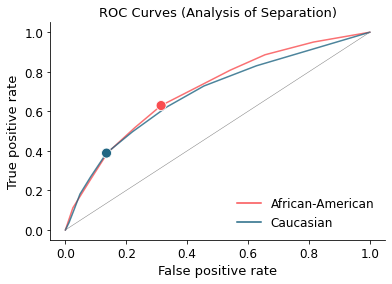

In [31]:
# Looking into roc curves
roc = fair_compas.layer_3(method = 'roc_curves')

### Independence Check Analysis
The plot shows that the independence criterion was violated because African-Americans are predicted to recidivate at a much higher rate than Caucasians. The errors bars (showing 95% Wilson confidence intervals) show that this difference cannot be attributed to random fluctuations. Again, either increasing the treshold for African-Americans or decreasing the threshold for Caucasians could mitigate the violation of the fairness criterion. 

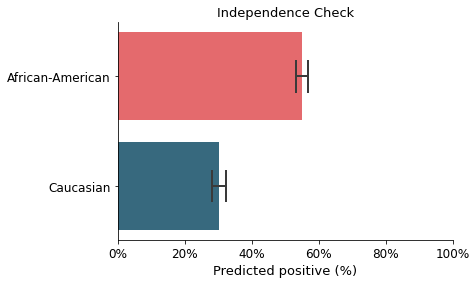

In [32]:
independence = fair_compas.layer_3(method = 'independence_check')

## Conclusion
The above analysis suggests that overall African-Americans could be discriminated by the predictions because they receive more unfavorable predictions than Caucasians. This is because African-Americans more often are predicted to recidivate, including when the prediction was correct, and more worringly also when the prediction was incorrect. The more in depth analyses showed that the threshold of `decile_score`=5 seemed to inflate the number of unfavorable predictions for African-Americans. 

This notebook shows how the tool `FairKit` can be used in an iterative manner to gain a more nuanced analysis of the unfairness in the predictions. The results from layer 2 made us use the in depth analyses `independence_check` and `roc_curves`. The output from the remaining available analysis methods in layer 3 are shown in the next section. 

## The remaining plots in layer 3

### False positive weight influence
The plots shows how calculated the weighted misclassification ratio changes as $w_{fp}$ changes. The more unfavorable a false prediction of recidivism is, the more African-Americans are discriminated. If it were worse to be predicted not to recidivate, then Caucasians would be discriminated slightly by the algorithm. 

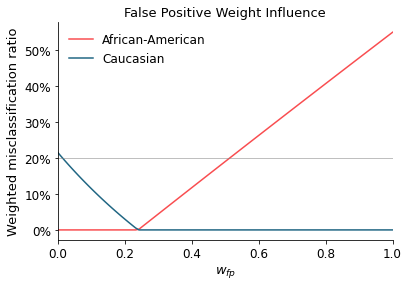

In [33]:
fair_compas.layer_3(method = 'w_fp_influence')

### Calibration analysis
The plot shows how well the predicted probabilities align with true probabilities (calculated as the proportion of true outcomes in the bin). The two groups behave similarly in this plots, which is also why only small separation values were seen in the unfairness barometer. 

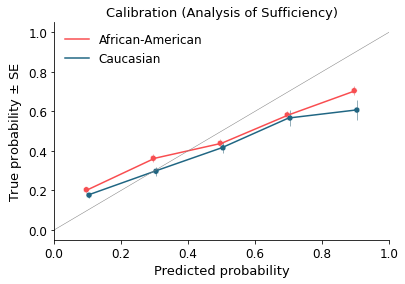

In [44]:
cal = fair_compas.layer_3(method = 'calibration', n_bins = 5)

### Confusion matrices 
The plot shows the confusion matrix by sensitive group. The percentages denote the percentage of the individuals in the sensitive group who received the specified combination of prediction and outcome. In the marginal labels we see how there are more actual positives and predicted positives among African-Americans. This different marginal distribution of outcomes for African-Americans could be a factor in why the number of false positives is also large in the group. 

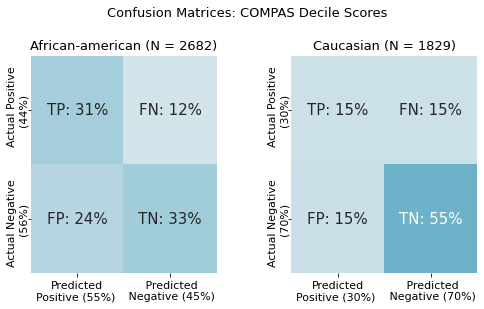

In [35]:
confusion = fair_compas.layer_3(method = 'confusion_matrix')